# Analysis of time-to-resolve Get It Done San Diego requests
## Notebook 4c: Machine Learning (Part 3)
### Evaluating Model Performance
The Random Forest Classifier was chosen as the best model for predicting the amount of time it takes to close a request in Part 1 (Notebook 4a), then the best hyperparameters were identified in Part 2 (Notebook 4b). This notebook documents evaluation of this final, tuned model. You can skip straight to Section XX for evaluation (data preprocssing in sections 1-XX are identical to those in Notebook 4a and 4b in order to have the same pre-processing flow). 

### 1 - Import libraries, import data and do some final cleaning

In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
notebook_path = os.path.abspath("Notebook4c-Machine_Learning_Part3.ipynb")

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, classification_report, roc_curve

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

#### *Discarding some requests* 
We will only use 'closed' requests because none of the other types (i.e. 'referred' or 'cancelled') have updated datetime information in the database. Almost all request types, from all sources (whether initiated by the public or city officials) are included in this model. The one exception is for 'Graffiti Removal' requests entered by City workers, because those requests are marked 'closed' as soon as they are entered into the database. My interpretation is that in this one case, City workers use the Get It Done database to log work that they've already completed, rather than to create records for work that needs to be done in the future.

In [3]:
filename_csv = os.path.join(os.path.dirname(notebook_path), "gid_with_demo.csv")
gid_with_demo = pd.read_csv(filename_csv, index_col=0)
gid_with_demo.set_index('service_request_id', inplace=True)
predictor_df = gid_with_demo.copy()

# Only use closed requests
predictor_df = predictor_df[predictor_df.status=='Closed']

# Remove Crew/Self Generated Graffiti Removal requests
predictor_df = predictor_df.drop(predictor_df[(predictor_df.case_origin == 'Crew/Self Generated') & 
                             (predictor_df.service_name == 'Graffiti Removal')].index)

# Get rid of service_name categories with low number of requests
predictor_df = predictor_df[predictor_df.groupby('service_name')['service_name'].transform('count').ge(100)]

# Drop all unneeded columns
predictor_df = predictor_df.drop(columns=['requested_datetime','updated_datetime','status',
                                          'lat','long','datetime_till_closed','resolved',
                                          'zipcode','housing_value','median_age'],axis=1)

# Get rid of any NaN values that may have slipped through
predictor_df = predictor_df.dropna(axis=0, how='any', subset=['service_name','case_record_type',
                                          'district','case_origin','days_till_closed','load_by_service',
                                          'load_by_service_zip','household_income','pop_density'])

### 2 - Preparation for model training, and training

#### *Add a column ('closed_bin') to use as labels for the classifier model*
These are the labels that will be used to train the model, and are based on the total number of days it takes to close a request. It's easier to add it to the dataframe here before normalization and splitting into test and training sets. The values for these particular labels were settled on after a bit of trial and error. Originally I'd used quintile values of the days_till_closed distribution, then tried quartile values. Given that those split points are arbitrary, and that the useful information to the user is more likely along the lines of "Will this request be resolved quickly or not?" I decided to use split points as follows:
- 0 = within a business week (5 days or less)
- 1 = between 1 week to 1 month
- 2 = between 1-2 months
- 3 = longer than 2 months

In [24]:
predictor_df['closed_bin'] = ''
predictor_df.loc[(predictor_df.days_till_closed < 6), 'closed_bin'] = 0
predictor_df.loc[((predictor_df.days_till_closed >= 6) & 
                  (predictor_df.days_till_closed < 31)), 'closed_bin'] = 1
predictor_df.loc[((predictor_df.days_till_closed >= 31) & 
                  (predictor_df.days_till_closed < 61)), 'closed_bin'] = 2
predictor_df.loc[(predictor_df.days_till_closed >= 61), 'closed_bin'] = 3

#### *Get dummy variables for categorical values*

In [25]:
predictor_df = pd.get_dummies(predictor_df, prefix=['service_name','case_record_type','district','case_origin'], 
                              columns=['service_name','case_record_type','district','case_origin'])

#### *Separate the training and test sets*
This is done *before* upsampling. We'll upsample the training set only so there is no 'bleed' through to the test set; in other words, no chance that the same record appears in both the training and testing set. I'm doing the train-test split manually below instead of using the sci-kit learn function, and *then* will separate into X and y sets.

In [26]:
import random

split = 0.75 # save 25% of data for test set
train = pd.DataFrame()
test = pd.DataFrame()
indices = np.array(range(len(predictor_df)))
random.Random(7).shuffle(indices)    # Random(XX) is the random seed for reproducibility
split_idx = int(len(indices) * split)
train = predictor_df.iloc[indices[:split_idx+1]]
test = predictor_df.iloc[indices[split_idx+1:]]

#### *Upsample the training data*

In [27]:
# Separate majority and minority classes
train_bin0 = train[train.closed_bin==0]
train_bin1 = train[train.closed_bin==1]
train_bin2 = train[train.closed_bin==2]
train_bin3 = train[train.closed_bin==3]

# The following n_majority will cause an out-of-memory error in code below.
n_majority = len(train[train.closed_bin==1])

# Instead, all classes will be either up- or down-sampled so that each class
# has exactly 20,000 requests (total of 80,000 requests)
# Upsample minority classes
#n_majority = 20000

train_bin0_resampled = resample(train_bin0,
                                  replace=True,          # sample with replacement
                                  n_samples=n_majority,  # to match majority class
                                  random_state=123)      # for reproducibility

#train_bin1_resampled = resample(train_bin1, replace=True, n_samples=n_majority, random_state=123)
train_bin2_resampled = resample(train_bin2, replace=True, n_samples=n_majority, random_state=123)
train_bin3_resampled = resample(train_bin3, replace=True, n_samples=n_majority, random_state=123)

# Combine majority class with upsampled minority class
train_resampled = pd.concat([train_bin0_resampled, train_bin1, train_bin2_resampled, 
                                 train_bin3_resampled])

print(train.closed_bin.value_counts())
print(train_resampled.closed_bin.value_counts())

1    52489
0    46371
3    21429
2    12050
Name: closed_bin, dtype: int64
3    52489
2    52489
1    52489
0    52489
Name: closed_bin, dtype: int64


#### *Create X and y datasets, train and fit model*

In [31]:
X_train = train_resampled.copy()
X_train = X_train.drop(columns=['days_till_closed', 'closed_bin'], axis=1).values
y_train = train_resampled['closed_bin'].values

X_test = test.copy()
X_test = X_test.drop(columns=['days_till_closed', 'closed_bin'], axis=1).values
y_test = test['closed_bin'].values

In [32]:
# instantiate RandomForestClassifier with best hyperparameters
# found from Part 2 (Notebook 4b)
rf = RandomForestClassifier(bootstrap=True,
                            max_depth=45,
                            max_features=15,
                            min_samples_leaf=1,
                            min_samples_split=2,
                            n_estimators=1600)
# Fit model
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=45, max_features=15, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1600, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### 3 - Model evaluation
#### *Performance on training data vs test data*

In [145]:
# Training data performance
y_pred = rf.predict(X_train)
print('\nTraining data performance')
print(pd.crosstab(y_train, y_pred, rownames=['Actual Bin'], colnames=['Predicted Bin'], normalize='index'))
print('Accuracy:', accuracy_score(y_train, y_pred))
print('f1 scores:', f1_score(y_train, y_pred, average='macro'))

# Test data performance
y_pred = rf.predict(X_test)
print('\nTest data performance')
print(pd.crosstab(y_test, y_pred, rownames=['Actual Bin'], colnames=['Predicted Bin'], normalize='index'))
print('Accuracy:', accuracy_score(y_test, y_pred))
print('f1 scores:', f1_score(y_test, y_pred, average='macro'))


Training data performance
Predicted Bin         0         1         2         3
Actual Bin                                           
0              0.992875  0.001353  0.001372  0.004401
1              0.003182  0.988588  0.002420  0.005811
2              0.000229  0.000095  0.998590  0.001086
3              0.000248  0.000457  0.001029  0.998266
Accuracy: 0.9945798167235039
f1 scores: 0.9945786032764151

Test data performance
Predicted Bin         0         1         2         3
Actual Bin                                           
0              0.609069  0.268623  0.048598  0.073710
1              0.157856  0.632679  0.095398  0.114067
2              0.108798  0.360099  0.335068  0.196035
3              0.086370  0.248679  0.122531  0.542420
Accuracy: 0.5825172288719622
f1 scores: 0.5256881122844013


#### *Trying to evaluate errors by subcategory*

In [146]:
service_name_list = test.columns[pd.Series(test.columns).str.startswith('service_name')]
predictions_by_service = pd.DataFrame(columns=('service_name', 'accuracy', 'f1_score'))

X_tmp = test.copy()
X_tmp = X_tmp.drop(columns=['days_till_closed', 'closed_bin'], axis=1)
y_tmp = test['closed_bin']

for name in service_name_list:
    tmp_idx = test.index[test[name]==1].tolist()
    mini_X = X_tmp.loc[tmp_idx].values
    mini_y = y_tmp.loc[tmp_idx].values
    mini_pred = rf.predict(mini_X)
    
    tmp_accuracy = accuracy_score(mini_y, mini_pred)
    tmp_f1 = f1_score(mini_y, mini_pred, average='macro')
    
    predictions_by_service = predictions_by_service.append({'service_name' : name, 
                                                           'accuracy' : tmp_accuracy,
                                                           'f1_score' : tmp_f1},
                                                          ignore_index=True)

/Users/marissawesterfield/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/marissawesterfield/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/marissawesterfield/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/marissawesterfield/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/U

In [159]:
print(predictions_by_service.sort_values('f1_score', ascending=False))
#print('\n\n',predictions_by_service.sort_values('f1_score', ascending=False).head(10))

                                         service_name  accuracy  f1_score
59       service_name_STREET LIGHT UNDERGROUND DAMAGE  0.649351  0.592724
32                     service_name_MISSED COLLECTION  0.965304  0.579375
31          service_name_ILLEGAL DUMPING FROM VEHICLE  0.520000  0.576389
71                service_name_TREE TRIMMING CONTRACT  0.820000  0.570088
33                                 service_name_OTHER  0.956633  0.536319
29                   service_name_HOMELESS ENCAMPMENT  0.600000  0.523052
52                    service_name_SIGNAGE EVALUATION  0.617647  0.499084
35                              service_name_OUT LATE  0.983333  0.495798
46                               service_name_POTHOLE  0.555023  0.477635
53  service_name_STORM WATER CODE ENFORCEMENT - IL...  0.871127  0.476184
64      service_name_TRAFFIC SIGNAL KNOCK OVER/DAMAGE  0.586207  0.475638
26                      service_name_GRAFFITI REMOVAL  0.610749  0.472847
30                       service_name_

In [147]:
X_train = train.copy()
X_train = X_train.drop(columns=['days_till_closed', 'closed_bin'], axis=1)

# Get numerical feature importances
importances = list(rf.feature_importances_)

# Get list of predictors to use later
predictor_list = list(X_train.columns)

# Get list of tuples with variable and importance
predictor_importances = [(predictor, round(importance, 2)) 
                         for predictor, importance in zip(predictor_list, importances)]

# Sort the feature importances by most important first
predictor_importances = sorted(predictor_importances, key = lambda x: x[1], reverse=True)

# Print out the feature and importances
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in predictor_importances]

Variable: load_by_service      Importance: 0.39
Variable: load_by_service_zip  Importance: 0.28
Variable: household_income     Importance: 0.04
Variable: pop_density          Importance: 0.04
Variable: service_name_STORM WATER CODE ENFORCEMENT - ILLEGAL DISCHARGE Importance: 0.03
Variable: case_origin_Crew/Self Generated Importance: 0.03
Variable: service_name_72 HOUR VIOLATION Importance: 0.01
Variable: service_name_GRAFFITI REMOVAL Importance: 0.01
Variable: service_name_MISSED COLLECTION Importance: 0.01
Variable: service_name_POTHOLE Importance: 0.01
Variable: case_record_type_ESD Complaint/Report Importance: 0.01
Variable: case_record_type_Parking Importance: 0.01
Variable: case_record_type_TSW Importance: 0.01
Variable: district_2           Importance: 0.01
Variable: district_3           Importance: 0.01
Variable: district_8           Importance: 0.01
Variable: case_origin_Mobile   Importance: 0.01
Variable: case_origin_Phone    Importance: 0.01
Variable: case_origin_Web      Imp

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

### Random Forest Interpreter

In [63]:
X_train_tmp = train_resampled.copy()
X_train_tmp = X_train_tmp.drop(columns=['days_till_closed', 'closed_bin'], axis=1)
y_train_tmp = train_resampled['closed_bin']

X_test_tmp = test.copy()
X_test_tmp = X_test_tmp.drop(columns=['days_till_closed', 'closed_bin'], axis=1)
y_test_tmp = test['closed_bin']

In [78]:
instances = X_train_tmp.iloc[[300, 309]]
np.array(instances.iloc[0]).reshape(1,-1)

array([[2.90000000e+02, 9.00000000e+00, 5.40600000e+04, 5.33617323e+03,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000000

In [95]:
from treeinterpreter import treeinterpreter as ti

instances = X_train_tmp.iloc[[300, 309]]
#instances = X_train_tmp.iloc[[300]]
print("Instance 0 prediction:", rf.predict(np.array(instances.iloc[0]).reshape(1,-1)))
print("Instance 1 prediction:", rf.predict(np.array(instances.iloc[1]).reshape(1,-1)))

Instance 0 prediction: [0]
Instance 1 prediction: [0]


In [96]:
prediction, bias, contributions = ti.predict(rf, instances)

In [109]:
for i in range(len(instances)):
    print("Instance", i)
    winner = np.argmax(prediction[i,])
    print("Predicted bin",winner)
    print("Bias (trainset mean)", bias[i,winner])
    print("Feature contributions:")
    for c, feature in sorted(zip(contributions[i,:,winner], 
                                 predictor_list), 
                             key=lambda x: -abs(x[0])):
        print(feature, round(c, 2))
    print("-"*20 )

Instance 0
Predicted bin 0
Bias (trainset mean) 0.2501476499838061
Feature contributions:
load_by_service_zip 0.2
district_6 0.14
load_by_service 0.11
household_income 0.07
service_name_POTHOLE -0.06
case_origin_Phone 0.04
pop_density 0.03
district_2 0.02
case_record_type_ESD Complaint/Report -0.02
service_name_TREE/LIMB FALLEN/HANGING -0.02
case_origin_Web 0.01
service_name_STREET LIGHT OUT 0.01
case_origin_Mobile 0.01
service_name_GRAFFITI REMOVAL -0.01
service_name_STREET SWEEPING -0.01
service_name_TRAFFIC SIGNAL LIGHT OUT 0.01
service_name_SIDEWALK REPAIR ISSUE 0.01
district_8 -0.01
service_name_MISSED COLLECTION -0.01
service_name_STORM WATER CODE ENFORCEMENT - ILLEGAL DISCHARGE 0.01
case_origin_Crew/Self Generated -0.0
case_record_type_Parking -0.0
service_name_GUARDRAILS/BARRIER METAL/WOODEN -0.0
case_record_type_Traffic Engineering 0.0
service_name_EVALUATE TREE FOR REMOVAL/ROOT PRUNE 0.0
service_name_TRAFFIC SIGNAL TIMING ISSUE -0.0
service_name_TRAFFIC SIGNAL OTHER PROBLEM 0

In [133]:
# The code for plotting confusion matrix graphs is from:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

from mpl_toolkits.axes_grid1 import make_axes_locatable
def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          maintitle=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    classes = ['0','1','2','3']
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,12))

    # Compute regular confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    title = 'Confusion matrix'
    
    im = ax1.imshow(cm, interpolation='nearest', cmap=cmap)
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    # We want to show all ticks...
    ax1.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax1.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax1.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
            
            
    # Compute normalized confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    title = 'Normalized confusion matrix'

    im = ax2.imshow(cm, interpolation='nearest', cmap=cmap)
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    # We want to show all ticks...
    ax2.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax1.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax2.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    titl_str = maintitle.replace('service_name_', "", 1)
    fig.suptitle(titl_str)
    fig.tight_layout()
    fig.subplots_adjust(top=1.4)
    return ax1, ax2

def get_datasets(name, model, test, X_tmp, y_tmp):
    tmp_idx = test.index[test[name]==1].tolist()
    mini_X = X_tmp.loc[tmp_idx].values
    mini_y = y_tmp.loc[tmp_idx].values
    mini_pred = rf.predict(mini_X)
    return mini_y, mini_pred


np.set_printoptions(precision=2)

X_tmp = test.copy()
X_tmp = X_tmp.drop(columns=['days_till_closed', 'closed_bin'], axis=1)
y_tmp = test['closed_bin']

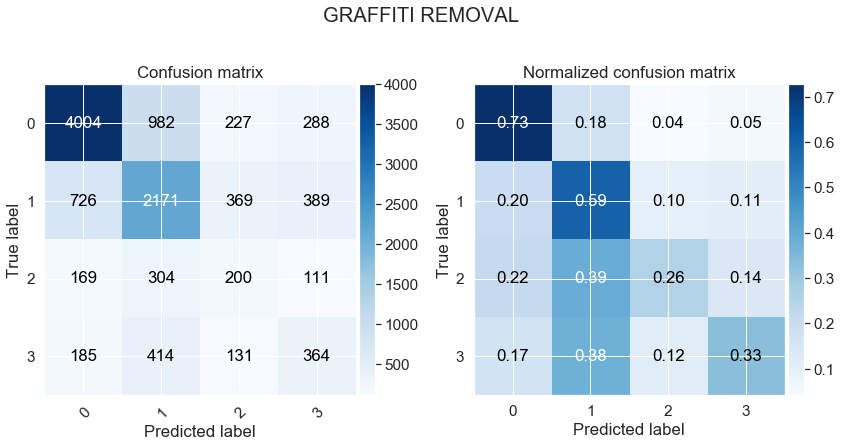

In [140]:
name = 'service_name_GRAFFITI REMOVAL'
mini_y, mini_pred = get_datasets(name, rf, test, X_tmp, y_tmp)
# Plot non-normalized confusion matrix
plot_confusion_matrix(mini_y, mini_pred,
                      maintitle=name)
#plt.savefig('CM_GraffitiRemoval.png')
plt.show()